In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import SimpleITK as sitk
import pickle as pkl
import torch
import cv2

from local_match import local_match
import sys
sys.path.append("../../")

from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2


In [2]:

import pickle as pkl
from cv2 import cvtColor

def to_grayscale(img):
    original_shape = img.shape[:2]
    img = cvtColor(img,cv2.COLOR_BGR2GRAY).astype(float)
    img /= np.max(img)
    return img
def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz

def get_slice_at(img, coord):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    l,p,s = coord
    
    return img[:,:,s]
def plot_img_at(img, coord, label='Target Location',
    vmin = 0.4,
    vmax = 0.8,ax=None):
    '''
        Plot the 3D slicing view of img at coord.
    '''
    img = np.array(img)
    img += -np.min(img)
    img /= np.max(img)
   
    l,p,s = coord
    
    
    target_marker = 'x'
    target_size = 50
    target_color = 'yellow'

  
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    
    # Only plot the horizontal slice.
    ax.imshow(np.squeeze(img[:,:,s]).T,cmap='gray',vmin=vmin,vmax=vmax)
    ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color,label=label)   
    return ax
def visualize_body(img,target_pixel=None,label=None,
                    vmin = 0.4,
                    vmax = 0.8,ax=None):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    if target_pixel is None:
        target_pixel = np.array(centroid3(img))
        label = 'Centroid location'
    plot_img_at(img,np.array(target_pixel,dtype=int),label,vmin,vmax,ax)
    
    
def flip_img(input_img,orders):
    flipped_ct = sitk.Flip(input_img,orders)
    flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
    flipped_ct.SetOrigin(input_img.GetOrigin())
    flipped_ct.SetSpacing(input_img.GetSpacing())
    return flipped_ct
def centroid2(img):
    nx, ny = img.shape
    print(nx,ny)
    
    imgx = np.sum(img, axis=1)
    imgy = np.sum(img, axis=0)

    denom = np.sum(img)
    
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    
    return cx, cy
def draw_us_box(ax,l,t,w,h,c='r',label=None):
    '''
        l is the coordinate for the center of the box.
        t is the coordinate for the top of the box.
        w, h are the width, height of the box.
    '''
    rect = patches.Rectangle((l-w/2,t), w, h, 
                             linewidth=1, edgecolor=c, facecolor='none',
                             label=label)
    # Add the patch to the Axes
    ax.add_patch(rect)
    return rect
def upper_boundary(slice,l): 
    m = np.argwhere(slice[:,l]>=0.6)
    if len(m)>0:
        return m[0,0]
    else:
        return np.inf

In [3]:
with open('us_observations.pkl','rb') as fp:
    data = pkl.load(fp)
target_locs = data['CT_target_locs']
origin = data['Observation Origin']
frames = data['frame']
body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])
vessel_ct = sitk.ReadImage('./nifty/vessel_ct.nii.gz')
vessel_ct = flip_img(vessel_ct,[True,False,False])

In [4]:
import yaml
with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)

# Spacing Units are mm.
xspacing = sp['xspacing'] 
yspacing = sp['yspacing']

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

vessel_model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

In [6]:
from time import time

Local match elapsed: 0.232283353805542


<Figure size 1500x600 with 0 Axes>

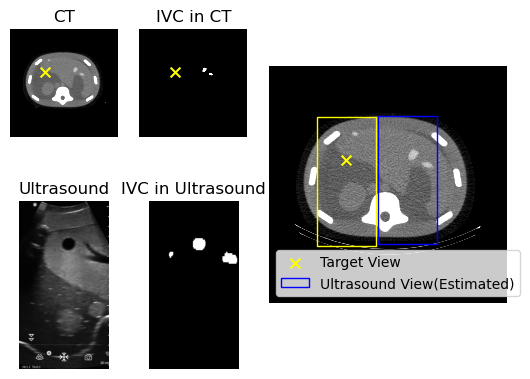

: 

In [7]:
for i in range(len(frames)):
    loc = target_locs[i]
    frame = frames[i]

    pix = body_ct.TransformPhysicalPointToIndex(loc)

    plt.figure(figsize=(15,6))

    fig, axs = plt.subplots(ncols=4, nrows=2)

    ax = axs[0,0]
    visualize_body(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)
    ax.set_title("CT")

    ax = axs[0,1]
    visualize_body(vessel_ct,pix,'Target Location',vmin=0.6,vmax=0.8,ax=ax)
    ax.set_title("IVC in CT")


    ax = axs[1,0]
    ax.axis('off')
    ax.imshow(to_grayscale(frame[100:1040]),cmap = 'gray')
    ax.set_title('Ultrasound')

    ax = axs[1,1]
    pred_mask = bunny_mask_predict(vessel_model,frame,device)
    ax.axis('off')
    ax.imshow(pred_mask[100:1040],cmap = 'gray')
    ax.set_title('IVC in Ultrasound')

    gs = axs[0, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[:, 2:].ravel():
        ax.remove()
    ax = fig.add_subplot(gs[0:, 2:])


     # Standardize the resolution for US and CT vessel slice images.b
    vessel_ct_slice = get_slice_at(vessel_ct,pix)
    vessel_ct_slice = sitk.GetImageFromArray(vessel_ct_slice)
    vessel_ct_slice.SetSpacing(vessel_ct.GetSpacing()[:2])

    vessel_us_slice = pred_mask.T
    vessel_us_slice = sitk.GetImageFromArray(vessel_us_slice)
    vessel_us_slice.SetSpacing([xspacing,yspacing])

    t = time()
    pos,am,box = local_match(vessel_ct_slice,vessel_us_slice)
    print("Local match elapsed:",time()-t)


    visualize_body(body_ct,pix,'Target View',vmin=0.6,vmax=0.8,ax=ax)
    img = sitk.GetArrayViewFromImage(body_ct).astype(float)
    img = np.swapaxes(img,0,2)
    img = np.array(img)
    img += -np.min(img)
    img /= np.max(img)
    l,p,s = pix
    slice = np.squeeze(img[:,:,s]).T
    t = upper_boundary(slice,l)
    w,h = np.array(frame.T.shape[1:])*np.array([xspacing,yspacing])/np.array(vessel_ct.GetSpacing()[:2])

    draw_us_box(ax,l,t,w,h,c='yellow')
    draw_us_box(ax,pos[1]+w/2,pos[0],w,h,c='blue',label='Ultrasound View(Estimated)')
    ax.legend()
    plt.show()
   